In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from mermaid import Mermaid
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from src.graph.nodes import (
    coordinator_node,
    reporter_node,
    research_team_node,
    researcher_node,
    coder_node,
    background_investigation_node,
)

## Setup
We'll need to  define some objects that continue_to_running_research_team and defining the graph's state depend on later

In [1]:
from pydantic import BaseModel, Field
from typing import List, Optional
from enum import Enum

class StepType(str, Enum):
    RESEARCH = "research"
    PROCESSING = "processing"


class Step(BaseModel):
    need_search: bool = Field(..., description="Must be explicitly set for each step")
    title: str
    description: str = Field(..., description="Specify exactly what data to collect")
    step_type: StepType = Field(..., description="Indicates the nature of the step")
    execution_res: Optional[str] = Field(
        default=None, description="The Step execution result"
    )


class Plan(BaseModel):
    locale: str = Field(
        ..., description="e.g. 'en-US' or 'zh-CN', based on the user's language"
    )
    has_enough_context: bool
    thought: str
    title: str
    steps: List[Step] = Field(
        default_factory=list,
        description="Research & Processing steps to get more context",
    )

    class Config:
        json_schema_extra = {
            "examples": [
                {
                    "has_enough_context": False,
                    "thought": (
                        "To understand the current market trends in AI, we need to gather comprehensive information."
                    ),
                    "title": "AI Market Research Plan",
                    "steps": [
                        {
                            "need_search": True,
                            "title": "Current AI Market Analysis",
                            "description": (
                                "Collect data on market size, growth rates, major players, and investment trends in AI sector."
                            ),
                            "step_type": "research",
                        }
                    ],
                }
            ]
        }


In [2]:
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class Resource(BaseModel):
    """
    Resource is a class that represents a resource.
    """

    uri: str = Field(..., description="The URI of the resource")
    title: str = Field(..., description="The title of the resource")
    description: str | None = Field("", description="The description of the resource")

class State(MessagesState):
    """State for the agent system, extends MessagesState with next field."""

    # Runtime Variables
    locale: str = "en-US"
    research_topic: str = ""
    observations: list[str] = []
    resources: list[Resource] = []
    plan_iterations: int = 0
    current_plan: Plan | str = None
    final_report: str = ""
    auto_accepted_plan: bool = False
    enable_background_investigation: bool = True
    background_investigation_results: str = None


## Nodes

In [3]:
from langchain_core.runnables import RunnableConfig
from langgraph.types import Command, interrupt
from typing import Annotated, Literal

def planner_node(
    state: State, config: RunnableConfig
) -> Command[Literal["human_feedback", "reporter"]]:
    """Planner node that generate the full plan."""
    logger.info("Planner generating full plan")
    configurable = Configuration.from_runnable_config(config)
    plan_iterations = state["plan_iterations"] if state.get("plan_iterations", 0) else 0
    messages = apply_prompt_template("planner", state, configurable)

    if state.get("enable_background_investigation") and state.get(
        "background_investigation_results"
    ):
        messages += [
            {
                "role": "user",
                "content": (
                    "background investigation results of user query:\n"
                    + state["background_investigation_results"]
                    + "\n"
                ),
            }
        ]

    if AGENT_LLM_MAP["planner"] == "basic":
        llm = get_llm_by_type(AGENT_LLM_MAP["planner"]).with_structured_output(
            Plan,
            method="json_mode",
        )
    else:
        llm = get_llm_by_type(AGENT_LLM_MAP["planner"])

    # if the plan iterations is greater than the max plan iterations, return the reporter node
    if plan_iterations >= configurable.max_plan_iterations:
        return Command(goto="reporter")

    full_response = ""
    if AGENT_LLM_MAP["planner"] == "basic":
        response = llm.invoke(messages)
        full_response = response.model_dump_json(indent=4, exclude_none=True)
    else:
        response = llm.stream(messages)
        for chunk in response:
            full_response += chunk.content
    logger.debug(f"Current state messages: {state['messages']}")
    logger.info(f"Planner response: {full_response}")

    try:
        curr_plan = json.loads(repair_json_output(full_response))
    except json.JSONDecodeError:
        logger.warning("Planner response is not a valid JSON")
        if plan_iterations > 0:
            return Command(goto="reporter")
        else:
            return Command(goto="__end__")
    if curr_plan.get("has_enough_context"):
        logger.info("Planner response has enough context.")
        new_plan = Plan.model_validate(curr_plan)
        return Command(
            update={
                "messages": [AIMessage(content=full_response, name="planner")],
                "current_plan": new_plan,
            },
            goto="reporter",
        )
    return Command(
        update={
            "messages": [AIMessage(content=full_response, name="planner")],
            "current_plan": full_response,
        },
        goto="human_feedback",
    )

In [4]:
def human_feedback_node(
    state,
) -> Command[Literal["planner", "research_team", "reporter", "__end__"]]:
    current_plan = state.get("current_plan", "")
    # check if the plan is auto accepted
    auto_accepted_plan = state.get("auto_accepted_plan", False)
    if not auto_accepted_plan:
        feedback = interrupt("Please Review the Plan.")

        # if the feedback is not accepted, return the planner node
        if feedback and str(feedback).upper().startswith("[EDIT_PLAN]"):
            return Command(
                update={
                    "messages": [
                        HumanMessage(content=feedback, name="feedback"),
                    ],
                },
                goto="planner",
            )
        elif feedback and str(feedback).upper().startswith("[ACCEPTED]"):
            logger.info("Plan is accepted by user.")
        else:
            raise TypeError(f"Interrupt value of {feedback} is not supported.")

    # if the plan is accepted, run the following node
    plan_iterations = state["plan_iterations"] if state.get("plan_iterations", 0) else 0
    goto = "research_team"
    try:
        current_plan = repair_json_output(current_plan)
        # increment the plan iterations
        plan_iterations += 1
        # parse the plan
        new_plan = json.loads(current_plan)
        if new_plan["has_enough_context"]:
            goto = "reporter"
    except json.JSONDecodeError:
        logger.warning("Planner response is not a valid JSON")
        if plan_iterations > 0:
            return Command(goto="reporter")
        else:
            return Command(goto="__end__")

    return Command(
        update={
            "current_plan": Plan.model_validate(new_plan),
            "plan_iterations": plan_iterations,
            "locale": new_plan["locale"],
        },
        goto=goto,
    )

In [2]:
def continue_to_running_research_team(state: State):
    current_plan = state.get("current_plan")
    if not current_plan or not current_plan.steps:
        return "planner"
    if all(step.execution_res for step in current_plan.steps):
        return "planner"
    for step in current_plan.steps:
        if not step.execution_res:
            break
    if step.step_type and step.step_type == StepType.RESEARCH:
        return "researcher"
    if step.step_type and step.step_type == StepType.PROCESSING:
        return "coder"
    return "planner"

In [3]:
def _build_base_graph():
    """Build and return the base state graph with all nodes and edges."""
    builder = StateGraph(State)
    builder.add_edge(START, "coordinator")
    builder.add_node("coordinator", coordinator_node)
    builder.add_node("background_investigator", background_investigation_node)
    builder.add_node("planner", planner_node)
    builder.add_node("reporter", reporter_node)
    builder.add_node("research_team", research_team_node)
    builder.add_node("researcher", researcher_node)
    builder.add_node("coder", coder_node)
    builder.add_node("human_feedback", human_feedback_node)
    builder.add_edge("background_investigator", "planner")
    builder.add_conditional_edges(
        "research_team",
        continue_to_running_research_team,
        ["planner", "researcher", "coder"],
    )
    builder.add_edge("reporter", END)
    return builder

In [4]:
def build_graph():
    """Build and return the agent workflow graph without memory."""
    # build state graph
    builder = _build_base_graph()
    return builder.compile()

In [5]:
graph = build_graph()

In [6]:
Mermaid(graph.get_graph(xray=True).draw_mermaid())

In [7]:
question = """What is the outlook for the cloud computing industry both in the west and emerging markets or regions?
What are some of the drivers of its growth and possible challenges or constraints?  What does the competitive landscape look like for leading
providers of cloud services?"""

In [8]:
initial_state = {
        # Runtime Variables
        "messages": [{"role": "user", "content": question}],
        "auto_accepted_plan": True,
        "enable_background_investigation": True,
    }

config = {
        "configurable": {
            "thread_id": "default",
            "max_plan_iterations": 1,
            "max_step_num": 3,
            "mcp_settings": {
                "servers": {
                    "mcp-github-trending": {
                        "transport": "stdio",
                        "command": "uvx",
                        "args": ["mcp-github-trending"],
                        "enabled_tools": ["get_github_trending_repositories"],
                        "add_to_agents": ["researcher"],
                    }
                }
            },
        },
        "recursion_limit": 100,
    }

================================ Human Message =================================

What is the outlook for the cloud computing industry both in the west and emerging markets or regions?
What are some of the drivers of its growth and possible challenges or constraints?  What does the competitive landscape look like for leading
providers of cloud services?
sync [
  {
    "type": "page",
    "title": "Cloud Computing Market Size, Trends, Growth Drivers - 2035",
    "url": "https://www.marketresearchfuture.com/reports/cloud-computing-market-1013",
    "content": "The Cloud Computing Market Industry is expected to grow from 318.98(USD Billion) in 2024 to 800 (USD Billion) by 2035.",
    "score": 0.6530611
  },
  {
    "type": "page",
    "title": "Cloud Industry Outlook Size, Share - Growth Analysis Report - 2032",
    "url": "https://www.marketsandmarkets.com/Market-Reports/cloud-industry-outlook-233205216.html",
    "content": "MarketsandMarkets anticipates that the global cloud market siz

Jina API key is not set. Provide your own key to access a higher rate limit. See https://jina.ai/reader for more information.


async [
  {
    "type": "page",
    "title": "Cloud Computing Market Forecast Report 2025-2035: Global",
    "url": "https://www.globenewswire.com/news-release/2025/06/11/3097849/28124/en/Cloud-Computing-Market-Forecast-Report-2025-2035-Global-Cloud-Computing-Market-Forecasted-to-Reach-3-50-Trillion-by-2035.html",
    "content": "The global cloud computing market is projected to soar from USD 766 billion in 2025 to USD 3.50 trillion by 2035, boasting a CAGR of 14.623%. Key growth drivers include hybrid cloud, SaaS, and AI technologies, while North America leads the charge. Microsoft, AWS, and Alibaba are pivotal players in this evolution. [...] Market Share by Geographical Regions\n\nBased on the geographical regions, the cloud computing market is segmented into North America, Europe, Asia, Latin America, Middle East and North Africa, and Rest of the World.",
    "score": 0.8170061,
    "raw_content": "Published Time: 6/11/2025 5:16:42 PM\n\nCloud Computing Market Forecast Report 2025-
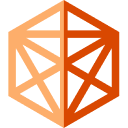
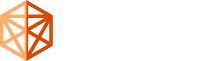

NameError: name 'logger' is not defined

In [10]:
last_message_cnt = 0
async for s in graph.astream(
    input=initial_state, config=config, stream_mode="values"
):
    try:
        if isinstance(s, dict) and "messages" in s:
            if len(s["messages"]) <= last_message_cnt:
                continue
            last_message_cnt = len(s["messages"])
            message = s["messages"][-1]
            if isinstance(message, tuple):
                print(message)
            else:
                message.pretty_print()
        else:
            # For any other output format
            print(f"Output: {s}")
    except Exception as e:
        logger.error(f"Error processing stream output: {e}")
        print(f"Error processing output: {str(e)}")

logger.info("Async workflow completed successfully")